In [1]:
!which python

/mnt/home/moham147/experiments/manifold-learning/.venv/bin/python


# Datasets

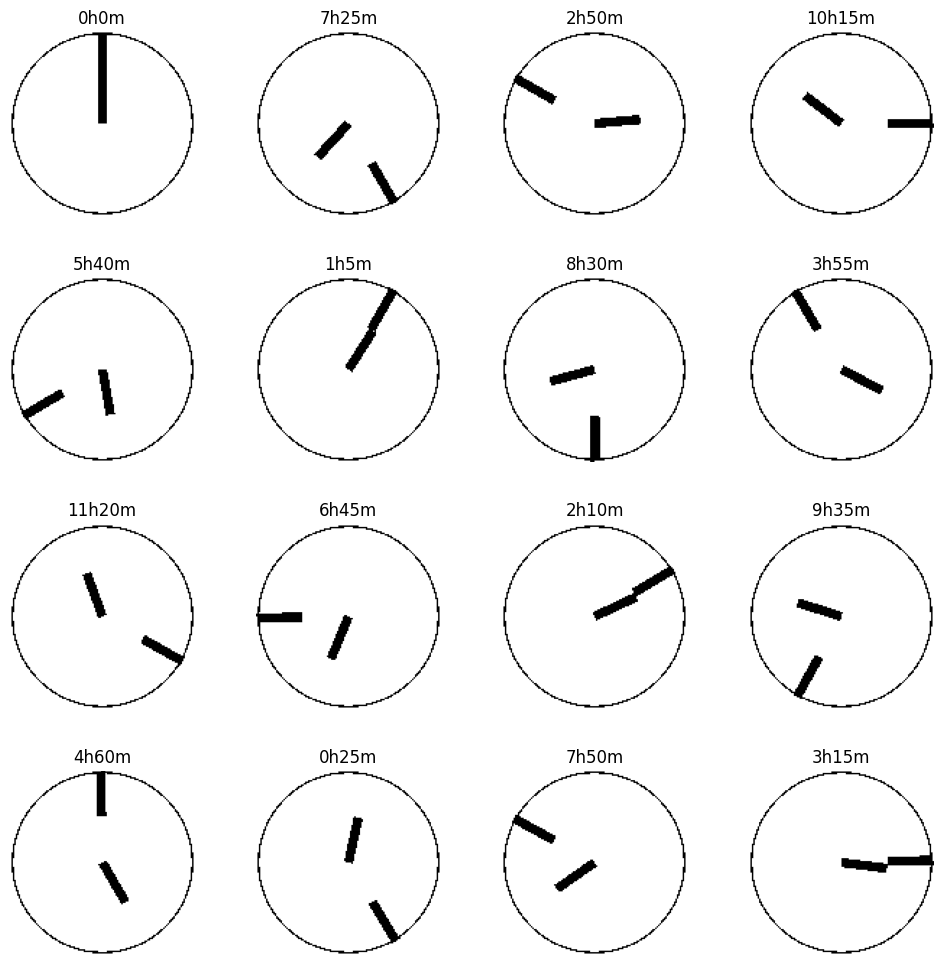

In [1]:
import torch
from torch.utils.data import DataLoader
from datasets.clock import ClockConfig, ClockDataset
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = 128
BATCH_SIZE = 64
data_size = 4096

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)


dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False, supervised=True, config=data_config)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# visualize 16 images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.tight_layout()
batch, labels2d, _ = next(iter(dataloader))
for i in range(16):
    img = batch[i].unsqueeze(0)
    label = labels2d[i].numpy()
    hour = label[0] * 12
    minute = label[1] * 60
    axs[i // 4, i % 4].imshow(img[0].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
    axs[i // 4, i % 4].axis('off')
# hour = label[0] * 12
# minute = label[1] * 60
# axs[i // 4, i % 4].imshow(img[0], cmap='gray')
# axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
# axs[i // 4, i % 4].axis('off')


plt.show()

# Models

In [2]:
from models import ConvInrAutoencoder, DeepAutoencoder, ResNetDecoderBlock
import torch

# IMG_SIZE = 256

model = ConvInrAutoencoder(img_size=IMG_SIZE, latent_dim=2)
img, _, _ = next(iter(dataloader))

y, _ = model(img)
y.shape 

# block = ResNetDecoderBlock(128, 64)
# y = block(img)
# y.shape



X shape torch.Size([16384, 256])
latent shape torch.Size([64, 2])
out shape torch.Size([64, 16384, 256])
X shape torch.Size([64, 16384, 256])
latent shape torch.Size([64, 2])
out shape torch.Size([64, 16384, 256])
INR out shape torch.Size([64, 16384, 1])


torch.Size([64, 1, 128, 128])

In [2]:
# forward pass
for i in range(10):
    img = torch.randn(16, 1, IMG_SIZE, IMG_SIZE)
    y = model(img)


KeyboardInterrupt: 

In [3]:
from models import DeepAutoencoder
ae = DeepAutoencoder(img_size=256,
                        latent_dim=2)

# count params
params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
print(f"Number of parameters: {params}")


Number of parameters: 9607699


Number of parameters: 46154059


Number of parameters: 64111947


In [5]:
import torch
print(f"Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Cached: {torch.cuda.memory_reserved()} bytes")


Allocated: 0 bytes
Cached: 0 bytes


## Visualize AE latents

In [1]:
import os
from datasets.clock import ClockDataset
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR

OUT_DIM = 2

def load_model_and_dataset(
    img_size=128,
    batch_size=64,
    data_size=2048,
    out_dim=2,
    postfix='',
    tag='model',
):
    """
    Load the model and dataset for inference.
    """
    # Load dataset
    dataset = ClockDataset(len=data_size, img_size=img_size, minute_hand_len=1, augment=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Load trained model
    model_file = f"ae-{out_dim}-i{img_size}{postfix}.pt"
    model_path = os.path.join(MODELS_DIR, tag, model_file)
    
    model = torch.jit.load(model_path).to(device)
    
    return model, dataloader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 256/256 [00:08<00:00, 31.36it/s]


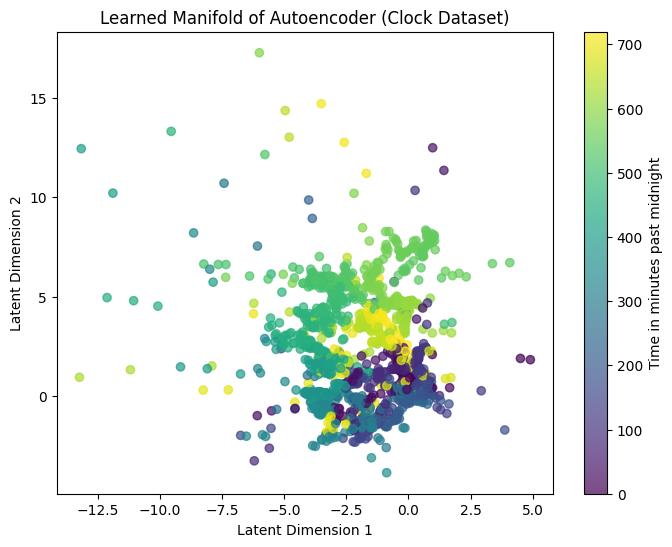

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm

torch.cuda.empty_cache()

model, dataloader = load_model_and_dataset(
    img_size=256,
    batch_size=8,
    out_dim=OUT_DIM,
    tag='DeepAutoencoder',
    postfix='-d22'
)

# Extract latent representations
latents = []
labels = []
labels2d = []

for batch, label2d, label1d in tqdm(dataloader):
    batch = batch.to(device)
    with torch.no_grad():
        _, latent = model.forward(batch)
    latents.append(latent.cpu().numpy())
    labels.append(label1d.numpy())
    labels2d.append(label2d.numpy())

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0) * (12 * 60)  # Denormalize to minutes past midnight
labels2d = np.concatenate(labels2d, axis=0)  # Denormalize to minutes past midnight

if (OUT_DIM <= 2):
  # Plot latent space
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(latents[:, 0], labels if OUT_DIM==1 else latents[:,1], c=labels, cmap="viridis", alpha=0.7)
  plt.colorbar(scatter, label="Time in minutes past midnight")
  plt.xlabel("Latent Dimension 1")
  plt.ylabel("Time in minutes past midnight" if OUT_DIM==1 else "Latent Dimension 2")
  plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
  plt.show()
else:
  # PCA for dimensionality reduction
  pca = PCA(n_components=2)
  latents_2d = pca.fit_transform(latents)

  # Plot PCA-reduced latent space
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
  plt.colorbar(scatter, label="Time in minutes past midnight")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")
  
  plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
  plt.show()
  


100%|██████████| 256/256 [00:20<00:00, 12.21it/s]


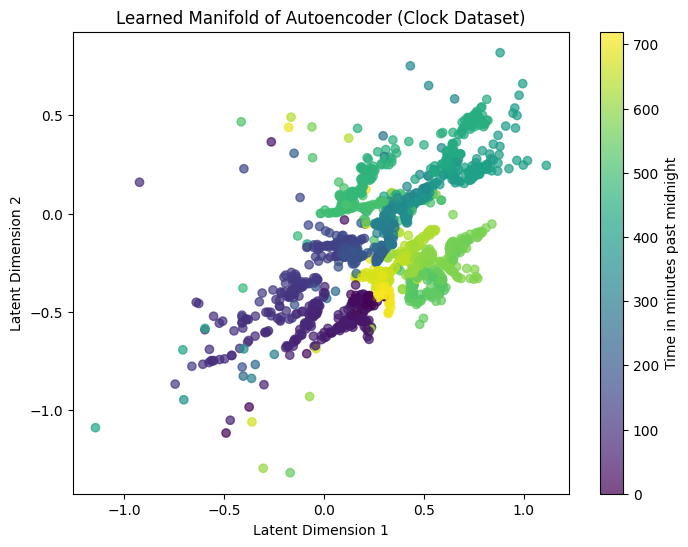

## Visualize reconstruction

In [4]:
i = iter(dataloader)

torch.Size([1, 1, 256, 256])


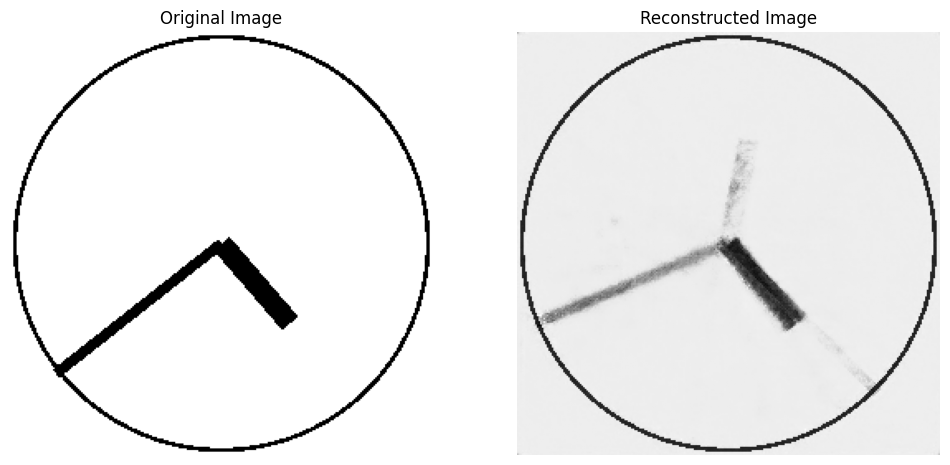

In [16]:
import matplotlib.pyplot as plt
import numpy as np


img = next(i)[0][0].unsqueeze(0)

print(img.shape)

out, latent = model.forward(img.to(device))
img = img.squeeze(0).detach().cpu().numpy()
out = out.squeeze(0).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out[0], cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


# Visualize Regressor latents

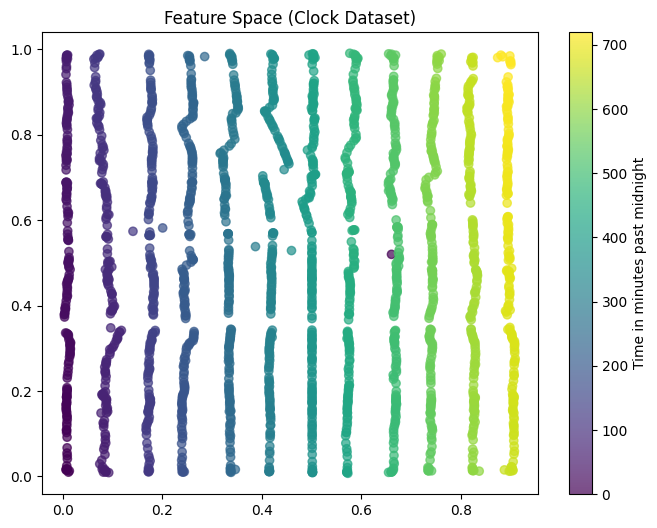

In [11]:
import os
from datasets.clock import ClockDataset
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
BATCH_SIZE = 64
IMG_SIZE = 128
data_size = 2048
dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)

# Load trained model
OUT_DIM = 2

# model_file = f"ae-{out_dim}-d22-p22-houronly.pt"
model_file = f"reg-{OUT_DIM}-d23-p18-i{IMG_SIZE}.pt"

model_path = os.path.join(MODELS_DIR, model_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()


# Extract latent representations
feats = []
feats_head1 = []
feats_head2 = []
labels1d = []
labels2d = []

with torch.no_grad():
  for images, label_2d, label_1d in dataloader:
    images = images.to(device)
    out = model.forward(images)

    feats.append(out.cpu().numpy())
    labels1d.append(label_1d.numpy())
    labels2d.append(label_2d.numpy())

    out1 = model.conv1(images)
    out_head1 = model.head1(out1)
    out_head2 = model.head2(out1)
    feats_head1.append(out_head1.cpu().numpy())
    feats_head2.append(out_head2.cpu().numpy())


feats = np.concatenate(feats, axis=0)
labels1d = np.concatenate(labels1d, axis=0) * (12 * 60)  # Denormalize to minutes past midnight
labels2d = np.concatenate(labels2d, axis=0)  # Denormalize to minutes past midnight

feats_head1 = np.concatenate(feats_head1, axis=0)
feats_head2 = np.concatenate(feats_head2, axis=0)

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feats[:, 0], feats[:, 1], c=labels1d, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Time in minutes past midnight")
plt.title("Feature Space (Clock Dataset)")
plt.show()



In [12]:
# Check examples of predicted vs true label

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets.clock import ClockDataset
from torch.utils.data import DataLoader
from config import MODELS_DIR
import os

# Load dataset
BATCH_SIZE = 64



(2048, 2)

## Attempt to predict labels using heads

Head differentiation: head1 predicts label0, head2 predicts label1.

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# try to predict first or second label using head1 and head2
# Predict first label using head1
def fit_mlp(feat_idx, x):
  y = labels[:, feat_idx]
  x_train, x_test, y_train, y_test = train_test_split(feats_head1, y, test_size=0.2, random_state=42)
  model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000)
  model.fit(x_train, y_train)

  y_pred = model.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)

  print(f"Mean Squared Error (Head 1): {mse}")

fit_mlp(0, feats_head1)
fit_mlp(1, feats_head1)
fit_mlp(0, feats_head2)
fit_mlp(1, feats_head2)


Mean Squared Error (Head 1): 988.7281494140625


/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (Head 1): 3669.49951171875
Mean Squared Error (Head 1): 879.5015869140625
Mean Squared Error (Head 1): 3783.881591796875


/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# UMAP

(2048,)

In [ ]:
# Do umap on the 

import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets.clock import IMG_SIZE, ClockDataset

BATCH_SIZE = 16
dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Sample the first 5000 data points
subset_size = 5000
subset_indices = np.random.choice(len(dataset), size=subset_size, replace=False)